# Study of the results of the NN for multiple noisy circles

This notebook studies teh results of the NN trained to predict PI from the multiple noisy circles dataset using the DTM filtration. 
   1. We compare the time of calculation of PIs between Gudhi and the NN,
   2. we look at the p-values of the Kolmogorov-Smirnov test on each pixels,
   3. we compare the classification results between a classifier trained on real PIs and trained on predicted PIs.

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from IPython.display import SVG

import gudhi as gd
import gudhi.representations
import velour2

from tqdm import tqdm
from time import time

from scipy.stats import ks_2samp

In [2]:
from multiple_noisy_circle import create_random_circle, create_1_circle, create_2_circle, create_3_circle

### Load the NN

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 600, 2)]          0         
_________________________________________________________________
fully_connected2_8 (FullyCon (None, 600, 30)           60        
_________________________________________________________________
tf.nn.relu_8 (TFOpLambda)    (None, 600, 30)           0         
_________________________________________________________________
dense_49 (Dense)             (None, 600, 20)           620       
_________________________________________________________________
dense_50 (Dense)             (None, 600, 10)           210       
_________________________________________________________________
lambda_8 (Lambda)            (None, 10)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 50)                550 

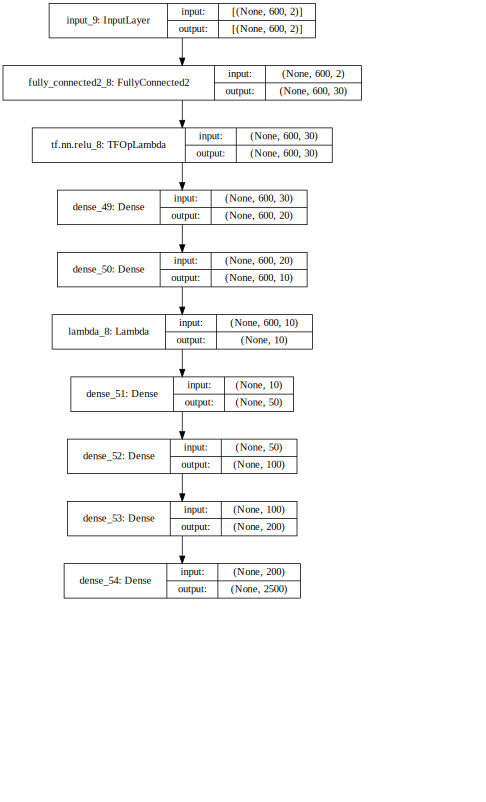

In [26]:
model_PI = tf.keras.models.load_model('../Trained_NN/model_multiple_noisy_circles/')
model_PI.summary()

SVG(
    tf.keras.utils.model_to_dot(model_PI,
                                show_shapes=True).create(prog='dot',
                                                         format='svg'))
#tf.keras.utils.plot_model(model_PI,
#to_file='dot_img_file.pdf',
#show_shapes=True,
#rankdir='LR')

## Comparaison of calculation time


We start by generating new data

In [4]:
N_sets = 10
N_points = 600
PI_size = 50

m = 0.1
p = 2
dimension_max = 2
filtration_max = 1

In [5]:
data_sets = np.zeros((N_sets, N_points, 2))

for i in tqdm(range(N_sets), desc='Generating dataset : '):
    data_sets[i] = create_random_circle(N_points)

Generating dataset : 100%|██████████| 10/10 [00:00<00:00, 159.57it/s]


We can plot the points clouds

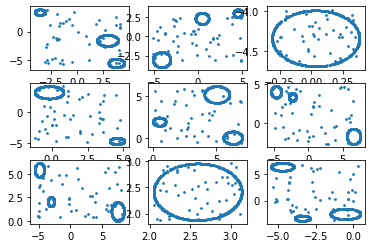

In [6]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.scatter(data_sets[i, :, 0], data_sets[i, :, 1], s=3)

### Compute their PI with the NN and save the time it took the NN

In [7]:
starttimeNN = time()
PI_NN = model_PI.predict(data_sets)
timeNN = time() - starttimeNN
print('Time taken by the NN = {} seconds'.format(timeNN))

Time taken by the NN = 0.34813809394836426 seconds


We can plot the predicted PIs

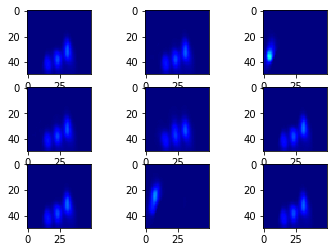

In [8]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.flip(np.reshape(PI_NN[i], [PI_size, PI_size]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')

### Compute their PI with Gudhi and save the time it took Gudhi

In [9]:
PI_gudhi = np.zeros((N_sets, PI_size * PI_size))

starttimeG = time()
for i in range(N_sets):
    st_DTM = velour2.DTMFiltration(
        data_sets[i], m, p, dimension_max=dimension_max, filtration_max=filtration_max)

    dgmX = st_DTM.persistence()

    PI = gd.representations.PersistenceImage(bandwidth=4e-2,
                                             weight=lambda x: 10 *
                                             np.tanh(x[1]),
                                             resolution=[PI_size, PI_size], im_range=[0, 1, 0, 0.5])
    pi = PI.fit_transform([st_DTM.persistence_intervals_in_dimension(1)])

    PI_gudhi[i] = pi[0]
timeG = time() - starttimeG
PI_gudhi /= np.max(PI_gudhi)
print('Time taken by Gudhi = {} seconds'.format(timeG))

Time taken by Gudhi = 135.19370102882385 seconds


We can plot the true PIs

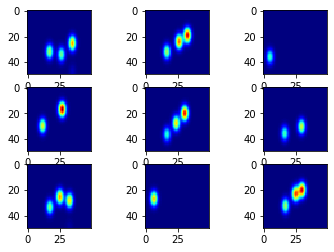

In [10]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.flip(
        np.reshape(PI_gudhi[i] / np.max(PI_gudhi), [PI_size, PI_size]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')

We compute the MSE between the true and predicted PIs.

In [11]:
(np.square(PI_NN - PI_gudhi)).mean(axis=None)

0.00887103534692287

## Time Results

|Number of point clouds  | Time taken by the NN in sec | Time taken by Gudhi in sec| Mean Squared Error |
|:----------------:|:--------------------:|:-------------------:|:------------------:|
|        10        |        0.04463       |       231       |       0.00235     |


## Kolmogorov-Smirnov test 

We test if the PI computed with the NN and the PI computed with Gudhi have the same distribution. 
$$(H_0) : D_{\text{NN}} = D_{\text{G}}$$
We use for that the Kolmogorov-Smirnov test. 

We start by loading the data already computed beacause the the true PIs take too much time to compute using the DTM filtration.

In [27]:
data = np.load('data/PI_data_multiple_noisy_circle_classif.npz')

data_train_classif = data["data_train"]
PI_train_gudhi = data["PI_train"]
PI_test_gudhi = data["PI_test"]
data_test_classif = data["data_test"]


In [28]:
PI_train_NN = model_PI.predict(data_train_classif)

In [30]:
p_value_ks = np.zeros(PI_NN[0].shape)
for i in range(len(p_value_ks)):
    p_value_ks[i] = ks_2samp(PI_train_NN[:, i], PI_train_gudhi[:, i]/np.max(PI_train_gudhi))[0]

Text(0.5, 1.0, 'Histogram of the p-values for the KS test on each pixels')

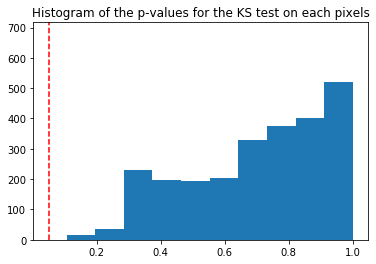

In [23]:
plt.hist(p_value_ks)
plt.vlines(0.05, 0, 800, linestyle='--', colors='red')
plt.ylim(0, 717)
plt.title("Histogram of the p-values for the KS test on each pixels")
#plt.savefig("Résultats/Résultats 4/hist_p_value_test_ks_noisy_circles.pdf")

No p-value is under 0.05, so all the KS tests are validated or at least we can not rejet $H_0$.

Text(0.5, 1.0, 'Heatmap of the p-values of the KS test on each pixels')

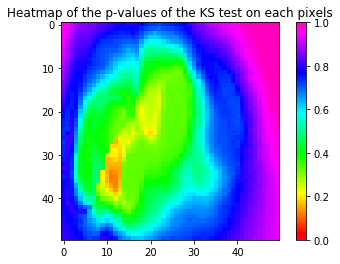

In [31]:
plt.imshow(np.flip(np.reshape(p_value_ks, [PI_size, PI_size]), 0),
           vmin=0,
           vmax=1,
           cmap='gist_rainbow')
plt.colorbar()
plt.title("Heatmap of the p-values of the KS test on each pixels")
#plt.savefig("Résultats/Résultats 4/heatmap_p_value_test_ks_noisy_circles.pdf")

-------

# Classification 

We want to compare the classification results between the true PIs and the predited PIs. For that, we create 2 models : ```model_classif_NN``` will be trained with the PI computed by the NN and ```model_classif_gudhi``` will be trained with the PI computed by Gudhi. We will then compare their accuracy on new data.

In [26]:
def create_model():
    inputs = tf.keras.Input(shape=(PI_size * PI_size))

    x = tf.keras.layers.Dense(100, activation='relu')(inputs)

    x = tf.keras.layers.Dense(50, activation='relu')(x)

    outputs = tf.keras.layers.Dense(3)(x)

    model_classif = tf.keras.Model(inputs=inputs, outputs=outputs)
    model_classif.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    return model_classif

In [27]:
model_classif_NN = create_model()
model_classif_gudhi = create_model()

model_classif_NN.summary()

#SVG(
#    tf.keras.utils.model_to_dot(model_classif,
#                                show_shapes=True).create(prog='dot',
#                                                         format='svg'))

#tf.keras.utils.plot_model(model_classif,
#                          to_file='Résultats/Résultats 2/model_classif_multip.pdf',
#                          show_shapes=True,
#                          rankdir='LR')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2500)]            0         
_________________________________________________________________
dense (Dense)                (None, 100)               250100    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 153       
Total params: 255,303
Trainable params: 255,303
Non-trainable params: 0
_________________________________________________________________


### Load data for the training of ```model_classif_gudhi```

In [39]:
data = np.load('data/PI_data_multiple_noisy_circle_classif.npz')

#data = np.load('PI_data_1000_dynamical_alpha.npz')

label_train_classif = data["label_train"]
data_train_classif = data["data_train"]
PI_train_gudhi = data["PI_train"]
label_test_classif = data["label_test"]
PI_test_gudhi = data["PI_test"]
data_test_classif = data["data_test"]

In [40]:
N_sets_train = PI_train_gudhi.shape[0]
N_sets_test = PI_test_gudhi.shape[0]
PI_size = int(np.sqrt(PI_train_gudhi.shape[1]))

In [41]:
print("N_sets_train : ", N_sets_train)
print("N_sets_test : ", N_sets_test)
print("PI_size : ", PI_size)

N_sets_train :  999
N_sets_test :  99
PI_size :  50


In [42]:
PI_train_gudhi /= max(np.max(PI_train_gudhi), np.max(PI_test_gudhi))
PI_test_gudhi /= max(np.max(PI_train_gudhi), np.max(PI_test_gudhi))

In [45]:
label_train_classif -= 1
label_test_classif -= 1

### Fit the classification model ```model_classif_gudhi```

In [28]:
history_gudhi = model_classif_gudhi.fit(PI_train_gudhi,
                                        label_train_gudhi,
                                        epochs=100,
                                        validation_data=(PI_test_gudhi,
                                                         label_test_gudhi))

Epoch 1/100
32/32 [==============================] - 1s 6ms/step - loss: 0.3145 - accuracy: 0.9730 - val_loss: 0.0334 - val_accuracy: 0.9899
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0179 - accuracy: 0.9990 - val_loss: 0.0233 - val_accuracy: 0.9899
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.0075 - val_accuracy: 1.0000
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 8/100
3

In [29]:
test_loss_gudhi, test_acc_gudhi = model_classif_gudhi.evaluate(
    PI_test_gudhi, label_test_gudhi, verbose=2)

print('\nTest accuracy:', test_acc_gudhi)

4/4 - 0s - loss: 1.6841e-05 - accuracy: 1.0000

Test accuracy: 1.0


 ### Predite the PIs for the training of ```model_classif_NN```  

In [34]:
PI_train_NN = model_PI.predict(data_train_classif)

In [35]:
PI_test_NN = model_PI.predict(data_test_classif)

### Fit the classification model ```model_classif_NN```

In [47]:
history_NN = model_classif_NN.fit(PI_train_NN,
                                  label_train_classif,
                                  epochs=100,
                                  validation_data=(PI_test_NN, label_test_classif))

Epoch 1/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2017 - accuracy: 0.9119 - val_loss: 0.2372 - val_accuracy: 0.8990
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1981 - accuracy: 0.9059 - val_loss: 0.2429 - val_accuracy: 0.8990
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1966 - accuracy: 0.9069 - val_loss: 0.2387 - val_accuracy: 0.8990
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1992 - accuracy: 0.9119 - val_loss: 0.2417 - val_accuracy: 0.8889
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1956 - accuracy: 0.9129 - val_loss: 0.2493 - val_accuracy: 0.8889
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2054 - accuracy: 0.9089 - val_loss: 0.2580 - val_accuracy: 0.8889
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1964 - accuracy: 0.9079 - val_loss: 0.2586 - val_accuracy: 0.8889
Epoch 8/100
3

Epoch 59/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2133 - accuracy: 0.9059 - val_loss: 0.2354 - val_accuracy: 0.8990
Epoch 60/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1890 - accuracy: 0.9109 - val_loss: 0.2218 - val_accuracy: 0.8788
Epoch 61/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1942 - accuracy: 0.9139 - val_loss: 0.2360 - val_accuracy: 0.8889
Epoch 62/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1907 - accuracy: 0.9109 - val_loss: 0.2353 - val_accuracy: 0.8889
Epoch 63/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1912 - accuracy: 0.9139 - val_loss: 0.2318 - val_accuracy: 0.8889
Epoch 64/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1890 - accuracy: 0.9149 - val_loss: 0.2205 - val_accuracy: 0.8990
Epoch 65/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1884 - accuracy: 0.9149 - val_loss: 0.2515 - val_accuracy: 0.8788
Epoch 

In [49]:
test_loss, test_acc = model_classif_NN.evaluate(PI_test_NN,
                                                label_test_classif,
                                                verbose=2)

print('\nTest accuracy:', test_acc)

4/4 - 0s - loss: 0.2396 - accuracy: 0.8788

Test accuracy: 0.8787878751754761


| Test accuracy for PI computed by Gudhi 	| Test accuracy for PI computed by NN 	|
|:--------------------------------------:	|:-----------------------------------:	|
|                   100%                  	|                 87%                 	|